In [1]:
import torch
import requests

from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();

# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False);
model.cuda()

CLIPDensePredT(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQu

In [ ]:
url="https://img.olympicchannel.com/images/image/private/t_s_w1340/t_s_16_9_g_auto/f_auto/v1671389197/primary/w8hzyw72ngg4m0hixlgp"
from PIL import Image
import matplotlib.pyplot as plt
import requests as req
from io import BytesIO
def read_url_img(url, show=False):
    response = req.get(url)
    image = Image.open(BytesIO(response.content))
    if show:
        plt.imshow(image)
    return image

In [2]:
# load and normalize image
input_image = Image.open('example_image.jpg')

# or load from URL...
# image_url = 'https://farm5.staticflickr.com/4141/4856248695_03475782dc_z.jpg'
# input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

Predict and visualize (this might take a few seconds if running without GPU support)

clip cost: 0.01845526695251465
cond cost: 0.07486772537231445
clipseg cost: 0.003607511520385742


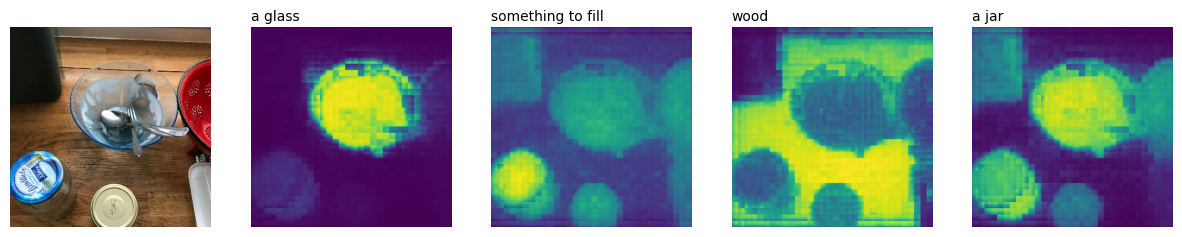

In [5]:
prompts = ['a glass', 'something to fill', 'wood', 'a jar']
img = img.cuda()
# predict
with torch.no_grad():
    preds = model(img.repeat(4,1,1,1), None, prompts, debug=True)[0]

# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0]).cpu()) for i in range(4)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(4)];

In [9]:
preds[0][0].shape

torch.Size([512, 512])

In [17]:
h = preds[0][0].flatten().topk(10)[1]//512
w = preds[0][0].flatten().topk(10)[1]%512
print(h, w)

tensor([186, 185, 184, 187, 201, 200, 199, 183, 188, 198], device='cuda:0') tensor([191, 191, 191, 191, 191, 191, 191, 191, 191, 191], device='cuda:0')


/tmp/ipykernel_3649623/1895198126.py:1: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  h = preds[0][0].flatten().topk(10)[1]//512


torch.Size([1024, 192])
cond cost: 0.019136667251586914
clipseg cost: 0.02370762825012207


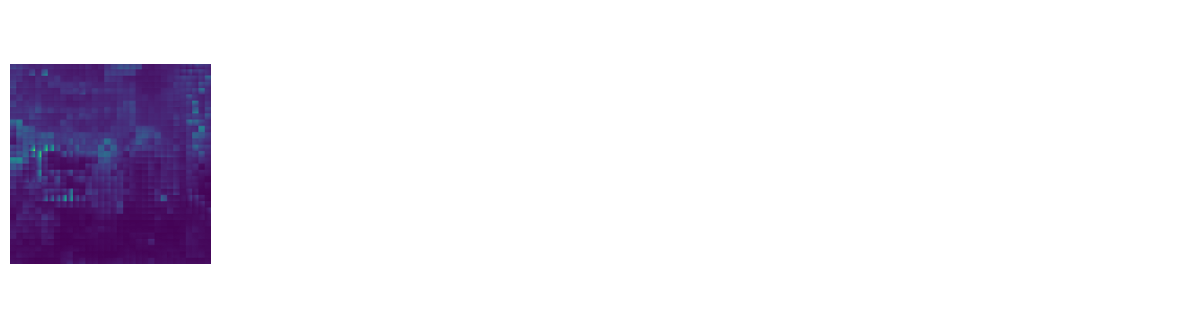

In [45]:
prompts = ['a man is cooking']
import numpy as np
feature = torch.from_numpy(np.load("/data/machine/nerfstudio/clipseg.npy")).cuda().reshape(1024, 192)
acts = []
for _i in range(3):
    _clipseg = feature[..., 64 * _i : 64 * (_i + 1)].reshape(-1, 64).unsqueeze(dim=1)
    _clipseg = torch.cat([_clipseg.mean(dim=0, keepdim=True), _clipseg], dim=0)
    acts.append(_clipseg)
print(feature.shape)
inp = {
    "visual_q": None,
    "activations": acts,
    "transformed_image_size": (32,32),
}
# predict
with torch.no_grad():
    preds = model(None, inp_feature=inp, conditional=prompts)[0][0][0]

# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(preds.sigmoid().cpu())

In [39]:
import os
os.system("ls /data/machine/nerfstudio/clipseg.npy")

/data/machine/nerfstudio/clipseg.npy


0

In [46]:
feature1 = torch.load("/data/machine/data/flame_salmon_image/clipseg_features/cam00_0001.pt")["activations"]
feature1 = torch.cat(feature1, dim=-1).squeeze()
print(feature1.shape)

feature2 = torch.from_numpy(np.load("/data/machine/nerfstudio/clipseg.npy")).cuda().reshape(1024, 192)

torch.Size([1025, 192])


In [53]:
((feature1[1:] - feature2)**2).mean()

tensor(1.3169, device='cuda:0')